In [184]:
import meep as mp
import numpy as np
import matplotlib.pyplot as plt
from autograd import numpy as npa
from autograd import tensor_jacobian_product, grad
import meep as mp
import meep.adjoint as mpa
import numpy as np
from autograd import numpy as npa
from autograd import tensor_jacobian_product, grad
import nlopt
from matplotlib import pyplot as plt
from matplotlib.patches import Circle
import math
import meep.adjoint as mpa

In [185]:
fontlabel = 16

lambda_min = 0.4       # 최소 파장 (µm)
lambda_max = 0.7       # 최대 파장 (µm)
fmin = 1/lambda_max    # 최소 주파수
fmax = 1/lambda_min    # 최대 주파수
fcen = 0.5*(fmin+fmax) # 중앙 주파수

resolution = 50        # 시뮬레이션 해상도
design_region_resolution = 50

# nfreq = 50             # 추출할 주파수 개수
df = fmax-fmin         # 주파수 대역폭

# df = 0
nfreq = 1

In [186]:
tpml = 0.5
tsio2 = 3
tair = 3

design_region_height = 0.5
design_region_width = 2

Sx = 2
Sy = tsio2+tair

sio2 = mp.Medium(index = 1.45)
air = mp.Medium(index = 1)

boundary_layers = [mp.PML(thickness = tpml, direction = mp.Y)]

Nx = int(100)
Ny = int(1)

design_region_resolution=Nx/design_region_width

y_bottom = -Sy / 2
center_y_sio2 = y_bottom + tsio2/2
center_y_air = y_bottom + tsio2+ tair/2

width_sio2 = Sx
width_air = Sx

cell_size = mp.Vector3(Sx, Sy)

In [187]:
geometry = [
    # SiO2 layer
    mp.Block(
        material=sio2,
        size=mp.Vector3(width_sio2, tsio2, 0),
        center=mp.Vector3(0, center_y_sio2, 0)
    ),
    mp.Block(
        material=air,
        size=mp.Vector3(width_air, tair, 0),
        center=mp.Vector3(0, center_y_air, 0)
    ),
]

region_height_each = design_region_height     # = 0.5

design_variables = mp.MaterialGrid(
        mp.Vector3(Nx, Ny),
        air,
        sio2,
        grid_type="U_MEAN",
        do_averaging=False
    )

design_region = mpa.DesignRegion(
    design_variables,
    volume=mp.Volume(
        center=mp.Vector3(0, 0, 0),
        size=mp.Vector3(design_region_width, region_height_each, 0),
    )
)

geometry.append(
    mp.Block(
        material=design_variables,
        size=design_region.size,
        center=design_region.center
    )
)

sources = [
    mp.Source(
        mp.GaussianSource(frequency=fcen, fwidth=df, is_integrated=True),
        component=mp.Ez,
        center=mp.Vector3(0, -2.5+2/resolution, 0),
        size = mp.Vector3(Sx, 0,0 )
    )
]

k0 = mp.Vector3(0,0,0)

sim = mp.Simulation(
    resolution = resolution,
    cell_size = cell_size,
    sources = sources,
    boundary_layers = boundary_layers,
    geometry = geometry,
    k_point = k0
)

In [201]:
mon_y      = 2
line_len   = Sx 
monitor_sz = mp.Vector3(line_len, 0, 0)

ff_45 = mpa.FourierFields(
    sim,
    mp.Volume(center=mp.Vector3(0, mon_y, 0), size=monitor_sz),
    mp.Ez,
    yee_grid=True
)

# --- 상수/파라미터 ---
theta_deg = 45.0
n_bg  = 1.0                            # 모니터 쪽 매질 굴절률(공기면 1)
k0    = 2 * np.pi * fcen * n_bg
dx    = 1.0 / resolution

# 각도 창 폭(표준편차) 설정: 대략 ±5~8° 범위
angle_halfwidth_deg = 6.0
sigma_kx = k0 * np.cos(np.deg2rad(theta_deg)) * np.deg2rad(angle_halfwidth_deg)

# 0° 억제용 좁은 창
sigma0_kx = 0.05 * k0

def J_45(fields_line):
    # 라인 위 필드 → kx 스펙트럼
    Ez = fields_line
    N  = Ez.size
    Ek = np.fft.fftshift(np.fft.fft(Ez)) * dx
    kx = 2*np.pi * np.fft.fftshift(np.fft.fftfreq(N, d=dx))
    Ik = np.abs(Ek)**2

    # 타깃 윈도우(+45°)
    kx_t = k0 * np.sin(np.deg2rad(theta_deg))
    Wt   = np.exp(-((kx - kx_t)**2) / (2*sigma_kx**2))

    # 0° 억제
    W0   = np.exp(-(kx**2) / (2*sigma0_kx**2))

    Pt   = np.sum(Ik) + 1e-18
    P_tg = np.sum(Ik * Wt) / Pt       # 목표 각도 정규화 파워
    P0   = np.sum(Ik * W0) / Pt       # 0° 정규화 파워
    Prest= 1.0 - P_tg                  # 타깃 외 파워(정규화)

    # 가중치 (필요 시 조정)
    alpha = 0.5   # 바깥 대역 패널티
    gamma = 0.2   # 0° 패널티

    # 최종 FoM (maximize)
    F = P_tg - alpha*Prest - gamma*P0
    return F


opt = mpa.OptimizationProblem(
        simulation=sim,
        objective_functions=[J_45],
        objective_arguments=[ff_45],
        design_regions=[design_region],  
        frequencies=[fcen],
        maximum_run_time=100,
    )

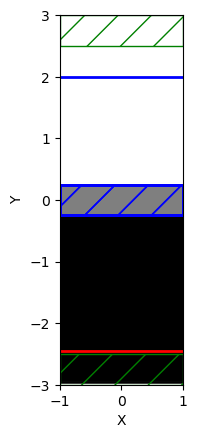

In [202]:
opt.plot2D(True)

In [203]:
class AdamOptimizer:
    def __init__(self, lr=0.01, beta1=0.9, beta2=0.999, epsilon=1e-8, warmup_iters=10):
        self.lr = lr
        self.beta1 = beta1
        self.beta2 = beta2
        self.epsilon = epsilon
        self.mt = None
        self.vt = None
        self.iter = 0
        self.warmup_iters = warmup_iters
    
    def update(self, v, gradient):
        if self.mt is None:
            self.mt = np.zeros_like(v)
        if self.vt is None:
            self.vt = np.zeros_like(v)
            
        #Adam에서는 기울기 값과 기울기의 제곱값의 지수이동평균을 활용하여 step 변회량을 조절
        self.iter += 1
        self.mt = self.beta1 * self.mt + (1 - self.beta1) * gradient           #m_(t)=beta_(1)*m_(t-1)+(1-beta_(1))*gradient
        self.vt = self.beta2 * self.vt + (1 - self.beta2) * (gradient ** 2)       #v_(t)=beta_(2)*v_(t-1)+(1-beta_(2))*(gradeint^2)
         
        # 초기 몇번의 update에서 0으로 편향되어 있어서 출발 지점에서 멀리 떨어진 곳으로 이동하는, 초기 경로의 편향 문제를 해결 하기 위해 unbiased하게 만들어줌
        m_hat = self.mt / (1 - self.beta1 ** self.iter)   #m_hat=m/(1-beta1**t)
        v_hat = self.vt / (1 - self.beta2 ** self.iter)
        
        # Warm-up 단계
        if self.iter <= self.warmup_iters:
            warmup_factor = self.iter / self.warmup_iters
            lr = self.lr * warmup_factor
        else:
            lr = self.lr   #lr_t <- alpha*sqrt
            
        #update = self.lr * m_hat / (np.sqrt(v_hat) + self.epsilon)
        update_factor= m_hat / (np.sqrt(v_hat) + self.epsilon) #theta_t <- theta_(t-1)-alpha_(t)*m_(t)/(sqrt(v_(t))+epsilon) alpha_(t)=learning rate
        update = lr * update_factor
        updated_v = v + update
        updated_v = np.clip(updated_v, 0.0, 1.0)
        
        adam_lr=np.mean(np.abs(update))
        adam_uf=np.mean(np.abs(update_factor))
        
        # adam_beta1=self.beta1
        # # adam_beta2=self.beta2
        adam_m=self.mt
        adam_v=self.vt
        adam_t=self.iter
        
        return updated_v, adam_lr, adam_uf, adam_m, adam_v, adam_t

In [204]:
layer_num = 1
eta_i = 0.5

def multi_mapping(x, eta, beta):    
    size_each = Nx * Ny

    v3 = x.reshape(layer_num, size_each)

    rho_list = []
    for i in range(layer_num):
        layer_field = v3[i].reshape(Nx, Ny)
        sym_field   = (layer_field[::-1, :] + layer_field) / 2
        flat        = sym_field.ravel()
        proj        = mpa.tanh_projection(flat, beta, eta)
        rho_list.append(proj)

    return npa.concatenate(rho_list, axis=0)


In [205]:
import os
import imageio

n = Nx * layer_num
np.random.seed(5)
# x = 0.4 + 0.2 * np.random.rand(n)  
x = np.ones(n)*0.5

frames_dir = "frames"
os.makedirs(frames_dir, exist_ok=True)

# 저장된 프레임 파일명 리스트
frame_files = []

cur_beta = 5

cur_iter             = [0]
evaluation_history   = []
beta_history         = []
binarization_history = []

g_histories   = [[] for _ in range(layer_num)]
x_histories   = [[] for _ in range(layer_num)]
lr_histories  = [[] for _ in range(layer_num)]
uf_histories  = [[] for _ in range(layer_num)]
t_histories   = [[] for _ in range(layer_num)]

optimizers = [AdamOptimizer(lr=0.02, beta1=0.9) for _ in range(layer_num)]

def f_multi(v, eta, beta):
    print(f"\n--- Iter {cur_iter[0]+1} ---")

    rho_full = multi_mapping(v, eta, beta)

    bin_deg = np.sum(np.abs(rho_full - 0.5)) / (0.5 * rho_full.size)
    binarization_history.append(bin_deg)

    size_each = Nx * Ny
    rho_list = [rho_full[i * size_each:(i + 1) * size_each] for i in range(layer_num)]

    f0_list = []
    dJ_list = []
    for i in range(len(opt_list)):
        f0_i, dJ_i = opt_list[i]([rho_full], need_value=True, need_gradient=True, beta=beta)
        f0_list.append(f0_i.flatten())
        dJ_list.append(dJ_i)

    dJ_total = np.mean(dJ_list, axis=0) # -> 3번째 트라이 바꾸는 부분
    dJ_flat = np.array(dJ_total).flatten()

    gradient_full = tensor_jacobian_product(multi_mapping, 0)(v, eta, beta, dJ_flat)

    grad_list = [gradient_full[i * size_each:(i + 1) * size_each] for i in range(layer_num)]
    vs = v.reshape(layer_num, size_each)
    v_new_layers = []
    for i in range(layer_num):
        vi_new, lr, uf, m, vt, t = optimizers[i].update(vs[i], grad_list[i])
        lr_histories[i].append(lr)
        uf_histories[i].append(uf)
        t_histories[i].append(t)
        g_histories[i].append(grad_list[i].copy())
        x_histories[i].append(vi_new.copy())
        v_new_layers.append(vi_new)
    v_new = np.concatenate(v_new_layers)

    f_vals = [float(np.abs(f0).item()) for f0 in f0_list]
    evaluation_history.append(f_vals)

    beta_history.append(beta)
    cur_iter[0] += 1

    if len(evaluation_history) >= 3:
        f_prev2 = evaluation_history[-3]
        f_prev1 = evaluation_history[-2]
        f_curr  = evaluation_history[-1]

        bin_prev2 = binarization_history[-3]
        bin_prev1 = binarization_history[-2]
        bin_curr  = binarization_history[-1]

        # FoM 기준 변화율 계산 (여기 부분 계속 수정중)
        change1 = abs(np.mean(f_curr)  - np.mean(f_prev1)) / (abs(np.mean(f_prev1)) + 1e-12)
        change2 = abs(np.mean(f_prev1) - np.mean(f_prev2)) / (abs(np.mean(f_prev2)) + 1e-12)

        bin_change1 = abs(bin_curr  - bin_prev1) / (abs(bin_prev1) + 1e-12)
        bin_change2 = abs(bin_prev1 - bin_prev2) / (abs(bin_prev2) + 1e-12)

        if (change1 < 0.003 and change2 < 0.003) and (bin_change1 < 0.001 and bin_change2 < 0.00075):
            if beta < 8:
                beta *= 1.3
            else:
                beta = beta + 5*np.tanh((beta - 0.5)*0.03)

    print(f"Current β: {beta:.3f}")
    print("FoM values:", f_vals)
    print(f"Mean FoM: {np.mean(f_vals):.6f}")

    print(f"Binarization degree: {bin_deg:.4f}")
    fig = plt.figure(figsize=(3, 2))

    ax = plt.gca()
    opt_list[0].plot2D(
        False,
        output_plane=mp.Volume(
            size=mp.Vector3(design_region_width, region_height_each * layer_num - 1 / resolution, 0),
            center=mp.Vector3(0, full_center_y, 0)
        ),
        ax=ax,
        show_sources=False,
        show_monitors=False,
        show_boundary_layers=False,
    )
    ax.axis("off")
    plt.show()

    # 2) 프레임으로 저장하기
    frame_filename = os.path.join(frames_dir, f"frame_{cur_iter[0]:03d}.png")
    fig.savefig(frame_filename, dpi=150, bbox_inches='tight')
    plt.close(fig)
    frame_files.append(frame_filename)

    return v_new, beta

mp.verbosity(0)
Max_iter = 30

while cur_iter[0] < Max_iter:
    x, cur_beta = f_multi(x, eta_i, cur_beta)
    if binarization_history[-1] > 0.95:
        print("Threshold reached → final mapping with β=∞")
        x, _ = f_multi(x, eta_i, np.inf)
        print("FOM increases : ", )
        break




--- Iter 1 ---


NameError: name 'opt_list' is not defined

In [206]:
def f_multi(v, eta, beta):
    print(f"\n--- Iter {cur_iter[0]+1} ---")

    rho_full = multi_mapping(v, eta, beta)

    bin_deg = np.sum(np.abs(rho_full - 0.5)) / (0.5 * rho_full.size)
    binarization_history.append(bin_deg)

    size_each = Nx * Ny
    # (참고) 필요 없다면 rho_list는 삭제 가능
    # rho_list = [rho_full[i * size_each:(i + 1) * size_each] for i in range(layer_num)]

    # --- 단일 opt 호출로 FoM, gradient 계산 ---
    f0, dJ = opt([rho_full], need_value=True, need_gradient=True, beta=beta)

    # 리스트 형태 유지(나중 평균/변화율 계산 로직 그대로 쓰려고)
    f_vals = [float(np.abs(f0).item())]
    evaluation_history.append(f_vals)

    # dJ_total 은 바로 dJ 사용(평균 불필요)
    dJ_total = dJ
    dJ_flat  = np.asarray(dJ_total).ravel()

    # 체인룰로 design 변수 그레이디언트
    gradient_full = tensor_jacobian_product(multi_mapping, 0)(v, eta, beta, dJ_flat)

    # 레이어별로 나눠서 Adam 업데이트
    grad_list = [gradient_full[i * size_each:(i + 1) * size_each] for i in range(layer_num)]
    vs = v.reshape(layer_num, size_each)
    v_new_layers = []
    for i in range(layer_num):
        vi_new, lr, uf, m, vt, t = optimizers[i].update(vs[i], grad_list[i])
        lr_histories[i].append(lr)
        uf_histories[i].append(uf)
        t_histories[i].append(t)
        g_histories[i].append(grad_list[i].copy())
        x_histories[i].append(vi_new.copy())
        v_new_layers.append(vi_new)
    v_new = np.concatenate(v_new_layers)

    beta_history.append(beta)
    cur_iter[0] += 1

    # --- β 업데이트 로직 그대로 유지 ---
    if len(evaluation_history) >= 3:
        f_prev2 = evaluation_history[-3]
        f_prev1 = evaluation_history[-2]
        f_curr  = evaluation_history[-1]

        bin_prev2 = binarization_history[-3]
        bin_prev1 = binarization_history[-2]
        bin_curr  = binarization_history[-1]

        change1 = abs(np.mean(f_curr)  - np.mean(f_prev1)) / (abs(np.mean(f_prev1)) + 1e-12)
        change2 = abs(np.mean(f_prev1) - np.mean(f_prev2)) / (abs(np.mean(f_prev2)) + 1e-12)

        bin_change1 = abs(bin_curr  - bin_prev1) / (abs(bin_prev1) + 1e-12)
        bin_change2 = abs(bin_prev1 - bin_prev2) / (abs(bin_prev2) + 1e-12)

        if (change1 < 0.003 and change2 < 0.003) and (bin_change1 < 0.001 and bin_change2 < 0.00075):
            if beta < 8:
                beta *= 1.3
            else:
                beta = beta + 5*np.tanh((beta - 0.5)*0.03)

    print(f"Current β: {beta:.3f}")
    print("FoM values:", f_vals)
    print(f"Mean FoM: {np.mean(f_vals):.6f}")
    print(f"Binarization degree: {bin_deg:.4f}")

    # --- 시각화: opt_list[0] → opt 로 변경 ---
    fig = plt.figure(figsize=(3, 2))
    ax = plt.gca()
    opt.plot2D(
        False,
        output_plane=mp.Volume(
            size=mp.Vector3(design_region_width, region_height_each * layer_num - 1 / resolution, 0),
            center=mp.Vector3(0, full_center_y, 0)
        ),
        ax=ax,
        show_sources=False,
        show_monitors=False,
        show_boundary_layers=False,
    )
    ax.axis("off")
    plt.show()

    frame_filename = os.path.join(frames_dir, f"frame_{cur_iter[0]:03d}.png")
    fig.savefig(frame_filename, dpi=150, bbox_inches='tight')
    plt.close(fig)
    frame_files.append(frame_filename)

    return v_new, beta

mp.verbosity(0)
Max_iter = 30

while cur_iter[0] < Max_iter:
    x, cur_beta = f_multi(x, eta_i, cur_beta)
    if binarization_history[-1] > 0.95:
        print("Threshold reached → final mapping with β=∞")
        x, _ = f_multi(x, eta_i, np.inf)
        print("FOM increases : ", )
        break


--- Iter 1 ---
Starting forward run...
Starting adjoint run...


TypeError: must be real number, not ArrayBox